In [1]:
import os
import torch
from models import get_model_gen
from commander import load_model
import numpy as np
import tqdm

Using backend: pytorch


Trying to continue without pyconcorde as it is not installed. TSP solving will fail.
Trying to continue without pyconcorde as it is not installed. TSP data generation will fail.


In [2]:
DIR = "interpretation"
model_name = "fgnn-l_3-s_0.13.tar"
DEVICE='cpu'

In [3]:
MODEL_CONFIG = {
    'arch': 'fgnn', #fgnn or gcn
    'arch_load': 'siamese', #siamese or simple
    'embedding': 'node', #node or edge
    'num_blocks': 2,
    'original_features_num': 2,
    'in_features': 64,
    'out_features': 64,
    'depth_of_mlp': 3,
    'input_embed': True
}
model = get_model_gen(MODEL_CONFIG)
print(model.node_embedder.base_model.embed)
model_full_path = os.path.join(DIR, 'best-' + model_name)
if not os.path.exists(model_full_path):
    raise FileNotFoundError("Model {} not found".format(model_full_path))
print("Loading model... ", end='')
model = load_model(model, DEVICE, model_full_path)
model.to(DEVICE)
print("Model loaded.")
print(model)

Fetching model fgnn siamese - (node  embedding if fgnn)
True
Loading model... Reading model from  interpretation/best-fgnn-l_3-s_0.13.tar
Model loaded.
Siamese_Model_Gen(
  (node_embedder): Simple_Node_Embedding(
    (base_model): BaseModel(
      (embedding): Embedding(2, 64)
      (reg_blocks): ModuleList(
        (0): RegularBlock(
          (mlp1): MlpBlock(
            (convs): ModuleList(
              (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
              (1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
              (2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            )
          )
          (mlp2): MlpBlock(
            (convs): ModuleList(
              (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
              (1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
              (2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            )
          )
          (mlp3): MlpBlock(
            (convs): ModuleList(
              

In [4]:
embedder = model.node_embedder.base_model.embedding
block1 = model.node_embedder.base_model.reg_blocks[0]
block2 = model.node_embedder.base_model.reg_blocks[1]

In [5]:
noedge = torch.zeros((1,1,2)).long()
yesedge = torch.zeros_like(noedge).long()
yesedge[0,0,1] = 1
selfedge = torch.zeros_like(noedge).long()
selfedge[0,0,0]= 0.5
ey,en = embedder(yesedge),embedder(noedge)
print(ey)

tensor([[[[ 0.8519,  0.1541,  0.8793,  1.1108, -1.1752, -0.1611,  0.1323,
            0.2504,  0.2113,  1.2297,  0.1152,  0.1188,  0.5634,  0.5424,
            0.5219,  0.3245,  0.5781,  0.4260, -0.5787, -0.8007,  1.2648,
            0.9133,  1.4423, -1.2676, -0.7026,  0.7927,  1.1110, -2.1015,
            0.5232, -0.2783, -2.1788, -0.5132, -0.6322,  0.5520,  0.7963,
            0.8866, -0.3187, -1.2405, -2.8597,  0.7352, -0.1916, -1.2897,
           -0.2167, -0.2455, -1.2472, -0.4724,  0.3032, -0.3552,  0.2591,
            0.4786,  2.3434,  0.4236, -0.0202,  0.8262, -0.1046, -1.8242,
            0.8747,  0.5531,  1.0053,  2.1043, -1.5605,  0.7599, -0.8780,
            0.7634],
          [-1.3854,  0.1713,  0.8841, -0.2138,  0.4547, -0.2600, -0.0417,
            1.3042,  0.9388, -1.7033,  0.0551, -0.1916,  0.6004, -1.5950,
            1.5300, -2.1404, -0.4988, -2.0402,  0.5926,  1.3899,  0.5793,
           -0.4032, -0.9481,  2.2668,  0.3063,  0.4730,  0.4154,  0.4490,
           -0.167

In [6]:
from loaders.data_generator import QAP_Generator
N = 100
lbda = 3
torch.manual_seed(0)
BASE_GEN_CONFIG = { 'num_examples_train': 1,
                'num_examples_val': 1,
                'num_examples_test': 1,
                'generative_model': 'ErdosRenyi', # so far ErdosRenyi, Regular or BarabasiAlbert
                'noise_model': 'ErdosRenyi',
                'vertex_proba': 1., # Parameter of the binomial distribution of vertices
                'path_dataset': 'dataset_qap', # Path where datasets are stored
                'edge_density': lbda/N,
                'n_vertices': N,
                'noise': 0
} #'edge_density' and 'noise' to be defined later
gen = QAP_Generator('train', BASE_GEN_CONFIG)
gen.load_dataset()
g = gen.data[0][0][0][:,:,1].unsqueeze(0).long()
print("G : ", g.shape)
embg = embedder(g).permute(0,3,1,2)
print("EmbG : ", embg.shape)
bg_torch = block1(embg)[0]
print(bg_torch.shape)
bg = bg_torch.detach().numpy()
bgflat = bg.reshape(64,N**2)
bgu = np.unique(bg.reshape(64,N**2),axis=1)
print(bgu.shape)

Reading dataset at dataset_qap/QAP_ErdosRenyi_ErdosRenyi_1_100_1.0_0_0.03/train.pkl
G :  torch.Size([1, 100, 100])
EmbG :  torch.Size([1, 64, 100, 100])
torch.Size([64, 100, 100])
(64, 2807)


In [7]:
from sklearn.cluster import KMeans
bgsk = bg.reshape(64,N**2).T
print(bgsk.shape)
kmeans = KMeans(n_clusters=2,random_state=0).fit(bgsk)
pred = kmeans.predict(bgsk)
adj = pred.reshape((N,N))
ta = torch.Tensor(adj)
print(torch.count_nonzero(ta),g.count_nonzero())
print(torch.count_nonzero(ta-g))

(10000, 64)
tensor(4686) tensor(296)
tensor(4502)


In [8]:
from sklearn.decomposition import PCA
n_comp = 8
pca = PCA(n_comp)
pca.fit(bgsk)
print(pca.explained_variance_ratio_)

[0.40978402 0.20017159 0.17119949 0.06316417 0.05602574 0.03159976
 0.01726994 0.01380325]


In [9]:
bgskpca = pca.transform(bgsk)
print(bgsk.shape,bgskpca.shape)

(10000, 64) (10000, 8)


Sanity check :  296  on  10000
Sanity check :  4686  on  10000


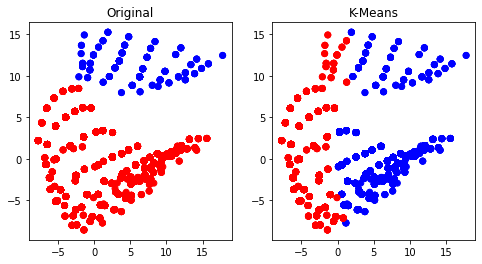

In [10]:
import matplotlib.pyplot as plt
c_orig = ['blue' if color==1 else 'red' for color in g.reshape(N**2)] #Blue if adjacent, red if not
print("Sanity check : ", sum([1 if color=='blue' else 0 for color in c_orig]), " on ", N**2)
c_pred = ['blue' if color==1 else 'red' for color in pred.reshape(N**2)] #Blue if adjacent, red if not
print("Sanity check : ", sum([1 if color=='blue' else 0 for color in c_pred]), " on ", N**2)
plt.figure(figsize=(8,4))
ax = plt.subplot(1,2,1)
ax.set_title('Original')
ax.scatter(bgskpca[:,0],bgskpca[:,1],c=c_orig)
ax2 = plt.subplot(1,2,2)
ax2.set_title('K-Means')
ax2.scatter(bgskpca[:,0],bgskpca[:,1],c=c_pred)
plt.show()


In [11]:
from sklearn.cluster import DBSCAN
from scipy.spatial import distance
eucdist = distance.cdist(bgflat,bgflat)
print(eucdist.mean())
dbscan=DBSCAN(eps=8)
dbscan.fit(bgsk)


131.6986230928356


DBSCAN(eps=8)

In [12]:
labels = dbscan.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
diff = g-(labels.reshape(N,N))
print("Difference with original labels : ", torch.count_nonzero(diff))


Estimated number of clusters: 2
Estimated number of noise points: 0
Difference with original labels :  tensor(0)


Sanity check :  296  on  10000


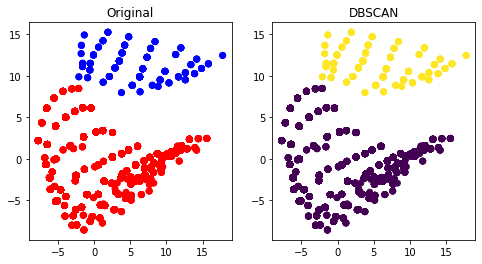

In [13]:
c_pred = ['blue' if color==1 else 'red' for color in labels] #Blue if adjacent, red if not
print("Sanity check : ", sum([1 if color=='blue' else 0 for color in c_pred]), " on ", N**2)
plt.figure(figsize=(8,4))
ax = plt.subplot(1,2,1)
ax.scatter(bgskpca[:,0],bgskpca[:,1],c=c_orig)
ax.set_title("Original")
ax2 = plt.subplot(1,2,2)
ax2.set_title("DBSCAN")
ax2.scatter(bgskpca[:,0],bgskpca[:,1],c=labels)
plt.show()


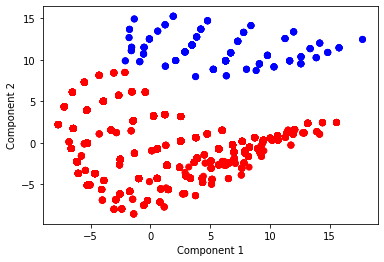

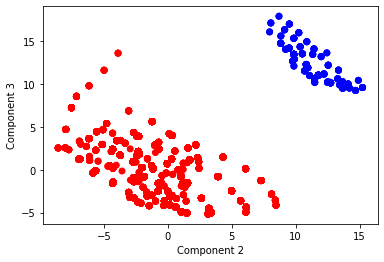

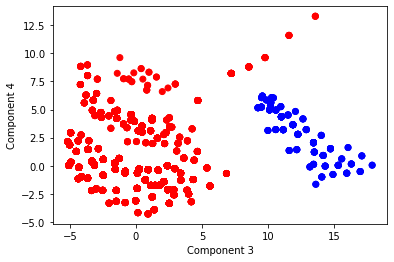

In [14]:
for i in range(3):
    plt.figure()
    plt.scatter(bgskpca[:,i],bgskpca[:,i+1],c=c_orig)
    plt.xlabel(f"Component {i+1}")
    plt.ylabel(f"Component {i+2}")
    plt.show()

In [15]:
from mpl_toolkits import mplot3d
DIR_MOVIE = 'movie'
if not os.path.exists(os.path.join(DIR,DIR_MOVIE,'image.gif')):
    for ii in tqdm.trange(0,360,1):
        fig = plt.figure(figsize=(8,8), dpi=100)
        ax = plt.axes(projection='3d')
        ax.scatter3D(bgskpca[:,0],bgskpca[:,1],bgskpca[:,2],c=c_orig)
        ax.view_init(elev=20,azim=ii)
        ax.set_xlabel("Component 1")
        ax.set_ylabel("Component 2")
        ax.set_zlabel("Component 3")
        plt.savefig(os.path.join(DIR,DIR_MOVIE,'image{}.png'.format(str(ii).zfill(3))))
        plt.close()

In [16]:
c_orig_ps = ['green' if i%N==0 else color for i,color in enumerate(c_orig)]
s_orig_ps = [30 if i%N==0 else 1 for i in range(N**2)]
in_degree = adj.sum(axis=-1)
print(in_degree.shape)
def get_conf_vector(i,j, adj):
    conf_vector = torch.zeros((4))
    N,_ = adj.shape
    conf_dict = {
        (0,0) : 0,
        (0,1) : 1,
        (1,0) : 2,
        (1,1) : 3
    }
    for k in range(N):
        if k!=i and k!=j:
            hik,hkj = adj[i,k], adj[k,j]
            #print(k,hik,hkj)
            conf_vector[conf_dict[(hik,hkj)]] += 1
    return conf_vector/98
def get_label_conf(i,j,adj):
    conf = get_conf_vector(i,j,adj)
    best = torch.argmax(conf)
    hij = adj[i,j]
    value =  (4*hij + best)
    return  int(value)
testi,testj = 1,2
print(get_conf_vector(testi,testj,adj))
print(adj[testi,testj],get_label_conf(testi,testj,adj))


(100,)
tensor([0.4082, 0.0306, 0.0612, 0.5000])
1 7


In [17]:
conf_labels = torch.zeros((N,N))
for i in range(N):
    for j in range(N):
        if i!=j:
            conf_labels[i,j] = get_label_conf(i,j,adj) + 1
conf_labels_flat = conf_labels.reshape((N**2))

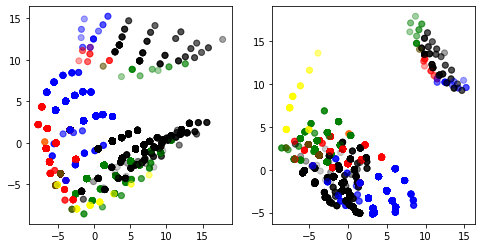

In [18]:
colors = ['yellow','red','green','blue','black','red','green','blue','black']
conf_c = [colors[int(i)] for i in conf_labels_flat]
plt.figure(figsize=(8,4))
ax = plt.subplot(1,2,1)
ax.scatter(bgskpca[:,0],bgskpca[:,1],c=conf_c,alpha=0.2)#,cmap='Set1')
ax2 = plt.subplot(1,2,2)
ax2.scatter(bgskpca[:,1],bgskpca[:,2],c=conf_c,alpha=0.2)#,cmap='Set1')
plt.show()


In [19]:
DIR_MOVIE = 'movie_colors'
if not os.path.exists(os.path.join(DIR,DIR_MOVIE,'image.gif')):
    for ii in tqdm.trange(0,360,1):
        fig = plt.figure(figsize=(8,8), dpi=100)
        ax = plt.axes(projection='3d')
        ax.scatter3D(bgskpca[:,0],bgskpca[:,1],bgskpca[:,2],c=conf_c,alpha=0.2)
        ax.view_init(elev=20,azim=ii)
        ax.set_xlabel("Component 1")
        ax.set_ylabel("Component 2")
        ax.set_zlabel("Component 3")
        plt.savefig(os.path.join(DIR,DIR_MOVIE,'image{}.png'.format(str(ii).zfill(3))))
        plt.close()

In [20]:
fout = block2(bg_torch.unsqueeze(0))
foutnp = fout.squeeze().detach().numpy()
foutsk = foutnp.reshape((64,N*N))
print(foutsk.shape)

(64, 10000)


In [21]:
n_comp_out = 8
pca_out = PCA(n_comp_out)
pca_out.fit(foutsk.T)
print("EVR : ", pca_out.explained_variance_ratio_)
foutpca = pca_out.transform(foutsk.T)
print(foutpca.shape)

EVR :  [0.499631   0.18137483 0.08678973 0.0811187  0.04294842 0.02616723
 0.01551117 0.01222905]
(10000, 8)


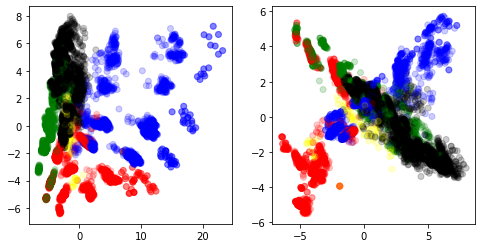

In [22]:
plt.figure(figsize=(8,4))
ax = plt.subplot(1,2,1)
ax.scatter(foutpca[:,0],foutpca[:,1],c=conf_c,alpha=0.2)#,cmap='Set1')
ax2 = plt.subplot(1,2,2)
ax2.scatter(foutpca[:,1],foutpca[:,2],c=conf_c,alpha=0.2)#,cmap='Set1')
plt.show()


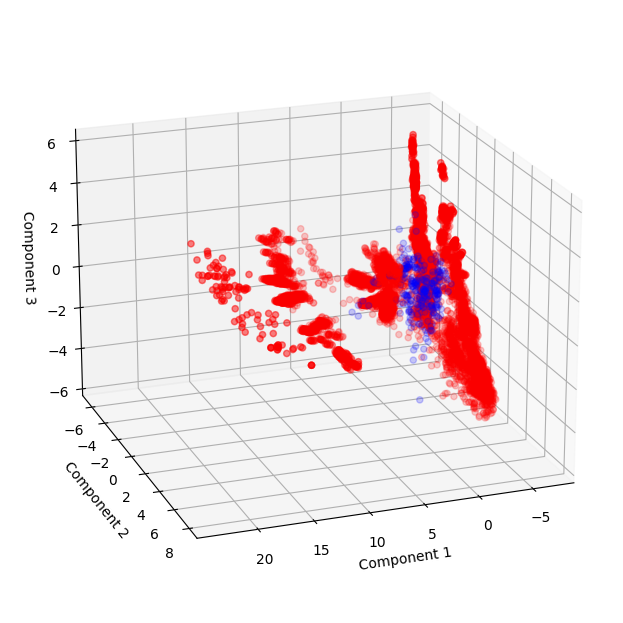

In [23]:
fig = plt.figure(figsize=(8,8), dpi=100)
ax = plt.axes(projection='3d')
ax.scatter3D(foutpca[:,0],foutpca[:,1],foutpca[:,2],c=c_orig,alpha=0.2)
ax.view_init(elev=20,azim=70)
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_zlabel("Component 3")
plt.show()

In [24]:
DIR_MOVIE = 'movie_colors_out'
if not os.path.exists(os.path.join(DIR,DIR_MOVIE,'image.gif')):
    for ii in tqdm.trange(0,360,1):
        fig = plt.figure(figsize=(8,8), dpi=100)
        ax = plt.axes(projection='3d')
        ax.scatter3D(foutpca[:,0],foutpca[:,1],foutpca[:,2],c=conf_c,alpha=0.2)
        ax.view_init(elev=20,azim=ii)
        ax.set_xlabel("Component 1")
        ax.set_ylabel("Component 2")
        ax.set_zlabel("Component 3")
        plt.savefig(os.path.join(DIR,DIR_MOVIE,'image{}.png'.format(str(ii).zfill(3))))
        plt.close()

In [25]:
DIR_MOVIE = 'movie_out'
if not os.path.exists(os.path.join(DIR,DIR_MOVIE,'image.gif')):
    for ii in tqdm.trange(0,360,1):
        fig = plt.figure(figsize=(8,8), dpi=100)
        ax = plt.axes(projection='3d')
        ax.scatter3D(foutpca[:,0],foutpca[:,1],foutpca[:,2],c=c_orig,alpha=0.2)
        ax.view_init(elev=20,azim=ii)
        ax.set_xlabel("Component 1")
        ax.set_ylabel("Component 2")
        ax.set_zlabel("Component 3")
        plt.savefig(os.path.join(DIR,DIR_MOVIE,'image{}.png'.format(str(ii).zfill(3))))
        plt.close()

In [26]:
### DISTANCES BETWEEN NODES
import networkx as nx

G = nx.from_numpy_array(adj)
dist = dict(nx.all_pairs_shortest_path_length(G))
npdist = np.infty * np.ones((N,N))
for i in range(N):
    for j in range(N):
        npdist[i,j] = int(dist[i][j])
print(np.unique(npdist))


[0. 1. 2.]


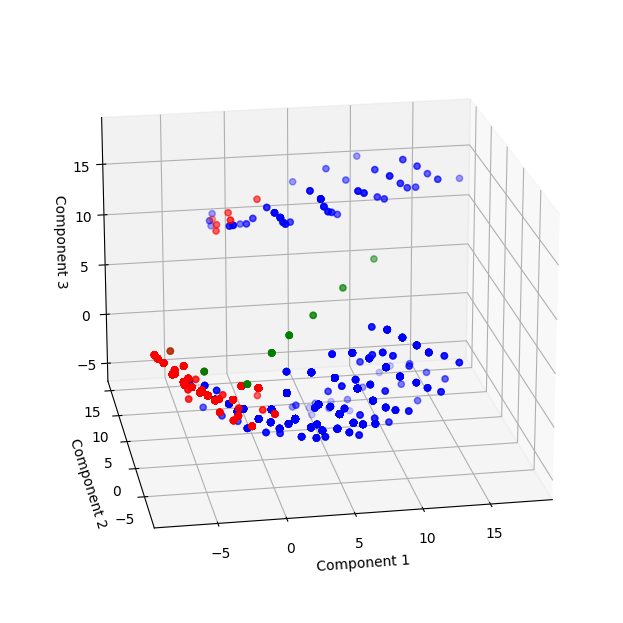

In [27]:
npdist_c = ['green' if distance==0 else 'blue' if distance==1 else 'red' for distance in npdist.reshape(N**2)]
fig = plt.figure(figsize=(8,8), dpi=100)
ax = plt.axes(projection='3d')
ax.scatter3D(bgskpca[:,0],bgskpca[:,1],bgskpca[:,2],c=npdist_c,alpha=0.2)
ax.view_init(elev=20,azim=-100)
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_zlabel("Component 3")
plt.show()

In [28]:
DIR_MOVIE = 'movie_out_dist'
if not os.path.exists(os.path.join(DIR,DIR_MOVIE,'image.gif')):
    for ii in tqdm.trange(0,360,1):
        fig = plt.figure(figsize=(8,8), dpi=100)
        ax = plt.axes(projection='3d')
        ax.scatter3D(bgsk[:,0],bgsk[:,1],bgsk[:,2],c=npdist_c,alpha=0.2)
        ax.view_init(elev=20,azim=ii)
        ax.set_xlabel("Component 1")
        ax.set_ylabel("Component 2")
        ax.set_zlabel("Component 3")
        plt.savefig(os.path.join(DIR,DIR_MOVIE,'image{}.png'.format(str(ii).zfill(3))))
        plt.close()

100%|██████████| 360/360 [10:42<00:00,  1.79s/it]


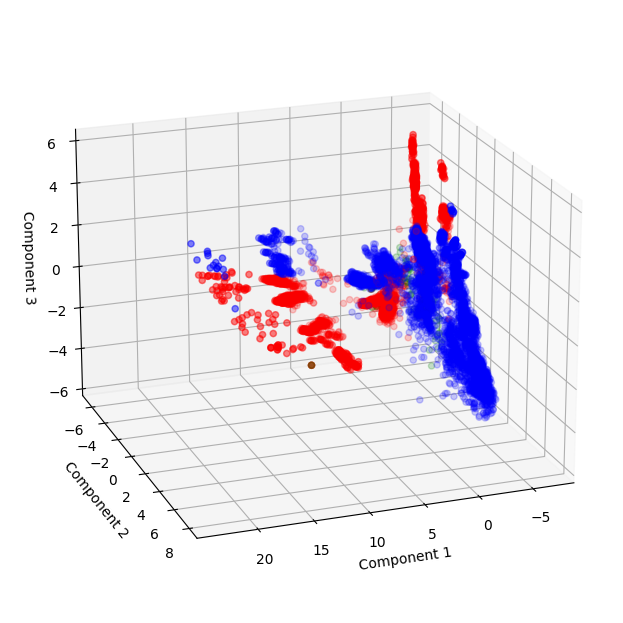

In [29]:
fig = plt.figure(figsize=(8,8), dpi=100)
ax = plt.axes(projection='3d')
ax.scatter3D(foutpca[:,0],foutpca[:,1],foutpca[:,2],c=npdist_c,alpha=0.2)
ax.view_init(elev=20,azim=70)
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_zlabel("Component 3")
plt.show()

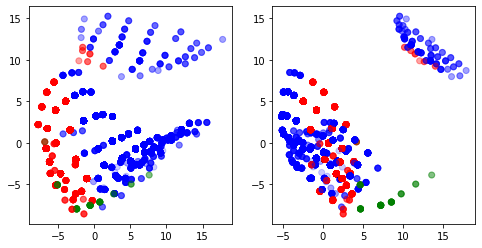

In [30]:
plt.figure(figsize=(8,4))
ax = plt.subplot(1,2,1)
ax.scatter(bgskpca[:,0],bgskpca[:,1],c=npdist_c,alpha=0.2)#,cmap='Set1')
ax2 = plt.subplot(1,2,2)
ax2.scatter(bgskpca[:,2],bgskpca[:,1],c=npdist_c,alpha=0.2)#,cmap='Set1')
plt.show()
